In [4]:
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [5]:
rutaDogsTrain = 'cat_dog_100/train/dog'
rutaDogsTest = 'cat_dog_100/test/dog'
rutaCatsTrain = 'cat_dog_100/train/cat'
rutaCatsTest = 'cat_dog_100/test/cat'

In [7]:
from os import walk

dogTrain = []
dogTest = []
catTest = []
catTrain = []
for (dirpath, dirnames, filenames) in walk(rutaDogsTrain):
    dogTrain.extend(filenames)
    
for (dirpath, dirnames, filenames) in walk(rutaDogsTest):
    dogTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTest):
    catTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTrain):
    catTrain.extend(filenames)

In [9]:
print(f'{rutaDogsTrain}/{dogTrain[0]}')

cat_dog_100/train/dog/dog.10000.jpg


In [26]:
def filtro(imagen, mascara):
    a = mascara.shape[0]//2
    b = mascara.shape[1]//2
    imagen_ampliada = cv2.copyMakeBorder(imagen, a, a, b, b, cv2.BORDER_REPLICATE)
    imagen2 = np.zeros(imagen.shape)
    for i in range(a, imagen.shape[0] + a):
        for j in range(b, imagen.shape[1] + b):
            imagen2[i-a, j-b] = np.sum(imagen_ampliada[i-a:i+a+1, j-b:j+b+1] * mascara)
            
    return imagen2

In [27]:
def gradiente(imagen):
    m_g_x = np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]])
    m_g_y = np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]])
    Ix = filtro(imagen, m_g_x)
    Iy = filtro(imagen, m_g_y)
    E = np.sqrt(Ix**2 + Iy**2)
    Phi = np.rad2deg(np.arctan2(Iy, Ix))
    
    return E, Phi

[[ -90.         -104.03624347  -93.57633437 ...   28.61045967
    80.53767779   84.28940686]
 [-123.69006753 -108.43494882  -94.08561678 ...    3.0127875
    81.86989765  105.9453959 ]
 [-116.56505118  -98.13010235  -90.         ...  -57.99461679
   156.80140949  146.30993247]
 ...
 [   0.            0.            0.         ...  172.87498365
   180.          163.30075577]
 [   0.            0.            0.         ...  -49.76364169
   -45.           54.46232221]
 [   0.            0.            0.         ...  -55.30484647
   -33.69006753   36.86989765]]
[[ 90 104  93 ...  28  80  84]
 [123 108  94 ...   3  81 105]
 [116  98  90 ...  57 156 146]
 ...
 [  0   0   0 ... 172 180 163]
 [  0   0   0 ...  49  45  54]
 [  0   0   0 ...  55  33  36]]


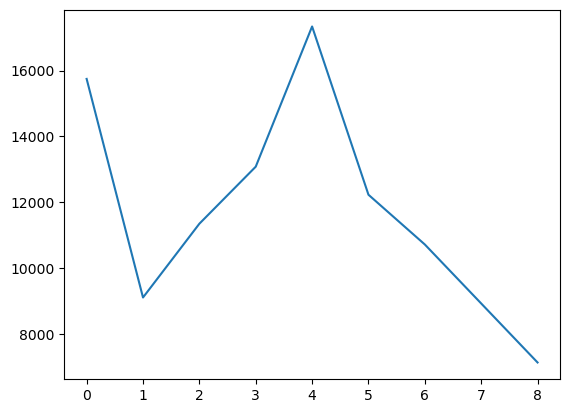

In [38]:
imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[0]}',0)
E, Phi = gradiente(imagen)
print(Phi)
Phi = np.uint8(np.abs(Phi))
print(Phi)
hp = cv2.calcHist([Phi], [0], None, [9], [0, 180])
plt.plot(hp)

In [39]:
def transforma_bloque2(celdaPhi, celdaE, bins = 9):
    celdaPhi = np.abs(celdaPhi)
    hp = cv2.calcHist([np.uint8(celdaPhi)], [0], None, [bins], [0, 180])
    a = 180/bins 
    for i in range(bins):
        hp[i] += np.sum(celdaE[(celdaPhi > a*i) & (celdaPhi < -a*(i+1))])
    hp = hp / np.sqrt(np.sum(hp**2))
    return np.ravel(hp)

In [40]:
def transforma_imagen2(imagen, sizeVentana, tamano):
    E, Phi = gradiente(imagen)
    Phi = resize_image(Phi, sizeVentana, tamano, True)
    E = resize_image(E, sizeVentana, tamano, True)
    caracteristicas = []
    a = int(Phi.shape[0]/sizeVentana)
    for i in range(a):
        for j in range(a):
            celdaPhi = Phi[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            celdaE = E[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            h = transforma_bloque2(celdaPhi, celdaE)  
            caracteristicas.append(h)
    return np.concatenate(caracteristicas)

In [41]:
imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[n]}',0)
caracteristicas = transforma_imagen2(imagen, sizeVentana, tamano)
print(caracteristicas)
print(caracteristicas.shape)

[0.48921788 0.43929768 0.4992019  ... 0.23136115 0.16826265 0.01051642]
(8649,)


In [23]:
tamano = 500
sizeVentana = 16
tamano = int(tamano/sizeVentana)*sizeVentana

In [24]:
def recorta_imagen(imagen, n):
    """
    Esta función recibe una imagen y un tamaño n y recorta la imagen de tal manera que el número final de filas/columnas 
    sea múltiplo de n. La funció debe recortar las filas de la derecha/abajo.
    """
    size = np.min([int(imagen.shape[0]/n)*n, int(imagen.shape[1]/n)*n])
    return imagen[:size, :size]

In [25]:
def resize_image(imagen, sizeVentana, tamano, recorta=False):
    if(recorta): imagen = recorta_imagen(imagen, sizeVentana)
    imagen2 = cv2.resize(imagen, [tamano,tamano])
    return imagen2

In [9]:
def ventana_a_decimal(ventana_binario):
    return ventana_binario[0,0]*2**7+ventana_binario[0,1]*2**6+ventana_binario[0,2]*2**5+ventana_binario[1,2]*2**4+ventana_binario[2,2]*2**3+ventana_binario[2,1]*2**2+ventana_binario[2,0]*2+ventana_binario[1,0]

In [10]:
def transforma_bloque(celda):
    celda_ampliada = cv2.copyMakeBorder(celda, 1, 1, 1, 1, cv2.BORDER_REPLICATE)
    celda2 = np.empty(celda.shape)
    for i in range(1, celda.shape[0]+1):
        for j in range(1, celda.shape[1]+1):
            ventana = celda_ampliada[i-1:i+2, j-1:j+2]
            ventana2 = np.zeros(ventana.shape)
            pixel_central = ventana[1,1]
            ventana2[ventana>pixel_central] = 1
            celda2[i-1,j-1] = ventana_a_decimal(ventana2)
    return celda2

In [31]:
def transforma_imagen(imagen, sizeVentana, tamano):
    imagen = resize_image(imagen, sizeVentana, tamano, True)
    #imagen2 = np.zeros(imagen.shape)
    caracteristicas = []
    a = int(imagen.shape[0]/sizeVentana)
    for i in range(a):
        for j in range(a):
            celda = imagen[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            nueva_celda = transforma_bloque(celda)
            #imagen2[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana] = nueva_celda
            caracteristicas.append(cv2.calcHist([np.uint8(nueva_celda)], [0], None, [256], [0, 256]).ravel())
    return np.concatenate(caracteristicas)

In [22]:
n = 2
imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[n]}',0)
caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
print(caracteristicas)
print(caracteristicas.shape)
cv2.imshow(f'{dogTrain[n]}', imagen)
cv2.imshow(f'{dogTrain[n]}_transformada', np.uint8(imagen2))
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'sizeVentana' is not defined

In [42]:
X = []
for i in tqdm(range(len(dogTrain)), desc = "Perros", colour = '#FF88F8'):
    imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    X.append(caracteristicas)

for i in tqdm(range(len(catTrain)), desc = "Gatos", colour = '#88FFDD'):
    imagen = cv2.imread(f'{rutaCatsTrain}/{catTrain[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    X.append(caracteristicas)
    
X = np.array(X)
y = np.hstack((np.ones(len(dogTrain)), np.zeros(len(catTrain)))).reshape(-1, 1)


Gatos: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [04:09<00:00,  2.49s/it]


In [43]:
Xtest = []
for i in tqdm(range(len(dogTest)), desc = "Perros Test", colour = '#FF88BB'):
    imagen = cv2.imread(f'{rutaDogsTest}/{dogTest[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    Xtest.append(caracteristicas)

for i in tqdm(range(len(catTest)), desc = "Gatos Test", colour = '#88FFE0'):
    imagen = cv2.imread(f'{rutaCatsTest}/{catTest[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamano)
    Xtest.append(caracteristicas)
    
Xtest = np.array(Xtest)
ytest = np.hstack((np.ones(len(dogTest)), np.zeros(len(catTest)))).reshape(-1, 1)

Gatos Test: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.48s/it]


In [45]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.15, random_state = 42)

(170, 246016)


In [42]:
X = []
for i in tqdm(range(len(dogTrain)), desc = "Perros", colour = '#FF88F8'):
    imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[i]}',0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamano)
    X.append(caracteristicas)

for i in tqdm(range(len(catTrain)), desc = "Gatos", colour = '#88FFDD'):
    imagen = cv2.imread(f'{rutaCatsTrain}/{catTrain[i]}',0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamano)
    X.append(caracteristicas)
    
X = np.array(X)
y = np.hstack((np.ones(len(dogTrain)), np.zeros(len(catTrain)))).reshape(-1, 1)


Gatos: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [05:23<00:00,  3.24s/it]


In [43]:
Xtest = []
for i in tqdm(range(len(dogTest)), desc = "Perros Test", colour = '#FF88BB'):
    imagen = cv2.imread(f'{rutaDogsTest}/{dogTest[i]}',0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamano)
    Xtest.append(caracteristicas)

for i in tqdm(range(len(catTest)), desc = "Gatos Test", colour = '#88FFE0'):
    imagen = cv2.imread(f'{rutaCatsTest}/{catTest[i]}',0)
    caracteristicas = transforma_imagen2(imagen, sizeVentana, tamano)
    Xtest.append(caracteristicas)
    
Xtest = np.array(Xtest)
ytest = np.hstack((np.ones(len(dogTest)), np.zeros(len(catTest)))).reshape(-1, 1)

Gatos Test: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [01:03<00:00,  3.15s/it]


In [44]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [62]:
print(Xtest)

[[0.18949048 0.29371026 0.14211786 ... 0.16690226 0.14603949 0.07301974]
 [0.0591571  0.0591571  0.07394637 ... 0.18219969 0.7490431  0.21256629]
 [0.48921788 0.43929768 0.4992019  ... 0.23136115 0.16826265 0.01051642]
 ...
 [0.3285263  0.39892477 0.48105633 ... 0.25530353 0.288604   0.17760246]
 [0.30940485 0.5868023  0.4587727  ... 0.24966161 0.07281797 0.0312077 ]
 [0.49209824 0.502796   0.2567469  ... 0.10673074 0.04851397 0.0097028 ]]


In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, TimeDistributed, GRU, SimpleRNN
import tensorflow.keras as keras

#Para ver si detecta la GPU (si no, hacer "conda install -c conda-forge cudnn" o algo así)
print(tf.config.list_physical_devices())
print("Número de GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Número de GPUs disponibles:  0


In [77]:
model = Sequential([
    Dense(64, input_shape = (8649, )),
    Dense(1, activation = 'sigmoid')
])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                553600    
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 553,665
Trainable params: 553,665
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.binary_crossentropy, metrics = ['acc'])

In [84]:
historico = model.fit(Xtrain, ytrain, validation_data= (Xval, yval), epochs = 16, batch_size = 100)

Epoch 1/16
2/2 [==============================] - 0s 76ms/step - loss: 0.1035 - acc: 1.0000 - val_loss: 0.6473 - val_acc: 0.7000
Epoch 2/16
2/2 [==============================] - 0s 36ms/step - loss: 0.1014 - acc: 1.0000 - val_loss: 0.6475 - val_acc: 0.7000
Epoch 3/16
2/2 [==============================] - 0s 38ms/step - loss: 0.0979 - acc: 1.0000 - val_loss: 0.6548 - val_acc: 0.7000
Epoch 4/16
2/2 [==============================] - 0s 38ms/step - loss: 0.0988 - acc: 1.0000 - val_loss: 0.6563 - val_acc: 0.7000
Epoch 5/16
2/2 [==============================] - 0s 35ms/step - loss: 0.0948 - acc: 1.0000 - val_loss: 0.6465 - val_acc: 0.7000
Epoch 6/16
2/2 [==============================] - 0s 35ms/step - loss: 0.0924 - acc: 1.0000 - val_loss: 0.6484 - val_acc: 0.7000
Epoch 7/16
2/2 [==============================] - 0s 35ms/step - loss: 0.0888 - acc: 1.0000 - val_loss: 0.6553 - val_acc: 0.7333
Epoch 8/16
2/2 [==============================] - 0s 36ms/step - loss: 0.0865 - acc: 1.0000 - val

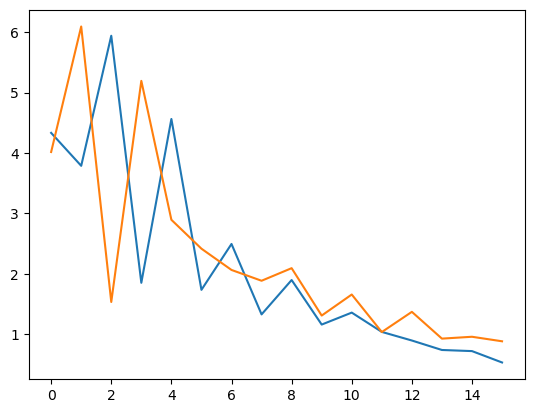

In [72]:
historial = historico.history
plt.plot(historial['loss'])
plt.plot(historial['val_loss'])

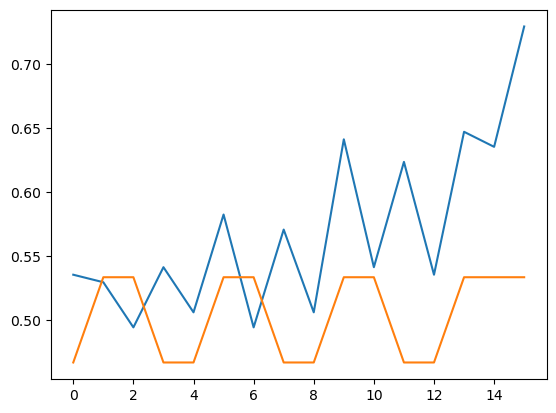

In [73]:
plt.plot(historial['acc'])
plt.plot(historial['val_acc'])

In [85]:
prediccion = model.predict(Xtest)
aciertos = np.sum(np.round(prediccion) == ytest)
print(f'{aciertos/ytest.shape[0]*100 }%')

2/2 [==============================] - 0s 3ms/step
75.0%


In [66]:
# Importamos las SVMs
from sklearn import svm
# Creamos un clasificador SVM usando svm.SVC con kernel='linear', C=1.0 y máximo número de iteraciones = 1000
svc = svm.SVC(kernel = 'linear', C = 1.0, max_iter = 10000)
svc

SVC(kernel='linear', max_iter=10000)

In [67]:
# Entrenamos el modelo
svc.fit(X, y.ravel())
# Obtenemos la precisión
accTrain = svc.score(X, y)
print("Precisión en train: {}%".format(accTrain*100))

Precisión en train: 100.0%


In [68]:
print(svc.score(Xtest, ytest))

0.8
